In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

import shapely
import shapely.geometry

import sys

sys.path.append('../src')

import SRRS
from SRRS import plotting,scoring,metrics

import glob
import os

In [2]:
sample = SRRS.HDF5('../inputs/m1s1_subset.hdf5')
sample

HDF5 ../inputs/m1s1_subset.hdf5

In [3]:
for cell in sample.iter_cells():
    if cell.n > 800:
        break

In [8]:
scored_cell = metrics.peripheral(cell)

In [16]:
#Finding highly peripheral and highly central genes for this specific cell
cell_info = pd.DataFrame({
    'gene':scored_cell.gene_med_ranks.keys(),
    'med_rank':scored_cell.gene_med_ranks.values(),
}).sort_values('med_rank')

cell_info['spot_count'] = cell_info['gene'].map(cell.gene_counts)
cell_info = cell_info[cell_info['spot_count'].ge(10)]
cell_info

,gene,med_rank,spot_count
28,Cbln2,235.0,14
36,C1ql3,261.0,13
48,Meis2,267.5,12
38,Syndig1,289.0,19
41,Wipf3,295.0,27
1,Ctss,318.5,34
106,Hpse,339.0,10
8,Cux2,348.0,11
23,Sertm1,396.0,29
14,Dscaml1,415.5,18


In [20]:
(cell.n+1)/2

518.0

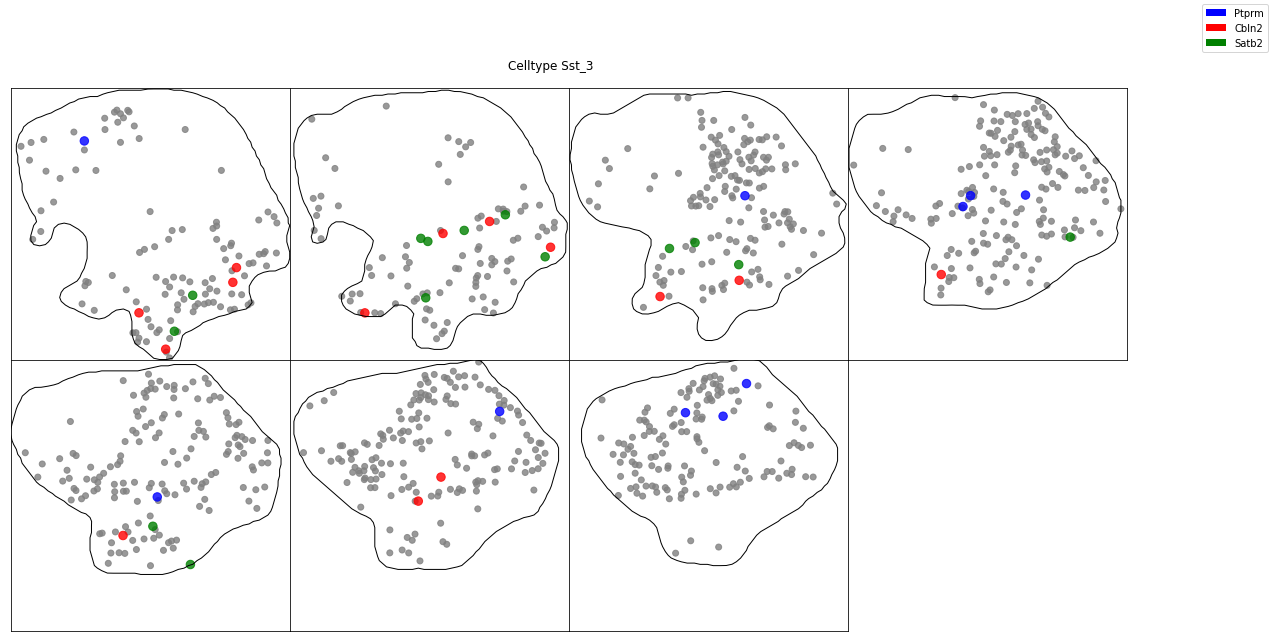

In [25]:
import importlib
importlib.reload(plotting)

gcs = {
    'Cbln2':'red',
    'Satb2':'green',
    'Ptprm':'blue',    
}


plotting.plot_cell_zslices(cell, gene_colors=gcs)
plt.show()
plt.close()

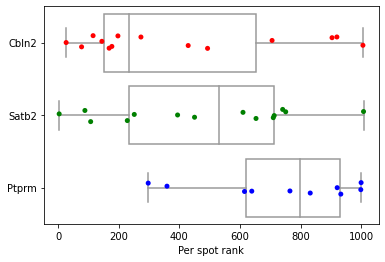

In [62]:
data = {
    'gene':[],
    'rank':[],
}
for z in cell.zslices:
    data['gene'].extend(cell.spot_genes[z])
    data['rank'].extend(cell.spot_ranks[z])
    
spot_ranks = pd.DataFrame(data)
spot_ranks = spot_ranks[spot_ranks['gene'].isin(['Cbln2','Satb2','Ptprm'])]

fig = plt.figure()

sns.stripplot(
    x = 'rank',
    y = 'gene',
    order = ['Cbln2','Satb2','Ptprm'],
    palette = ['red','green','blue'],
    data = spot_ranks,
)
sns.boxplot(
    x = 'rank',
    y = 'gene',
    order = ['Cbln2','Satb2','Ptprm'],
    color = 'white',
    data = spot_ranks,
)
plt.xlabel('Per spot rank')
plt.ylabel('')
plt.savefig('figure1_plots/spot_ranks.svg')
plt.show(fig)
plt.close()

In [66]:
def score(obs_med, n):
    """
    Calculate SRRS score from median observed rank
    """
    if obs_med == None:
        return None

    exp_med = (n+1)/2
    eff = (exp_med-obs_med)/(exp_med-1)
    return eff


In [69]:
score(cell.gene_med_ranks['Ptprm'], cell.n)


-0.5425531914893617

530.0

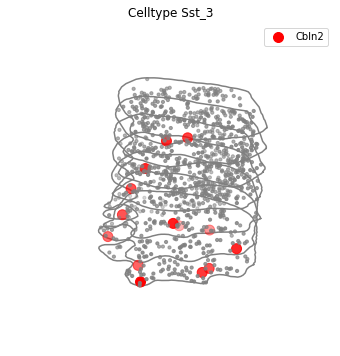

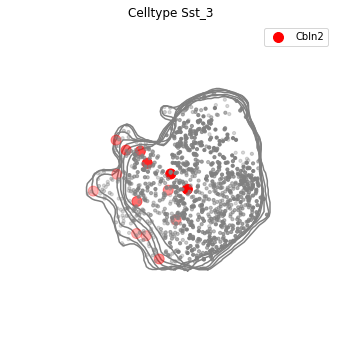

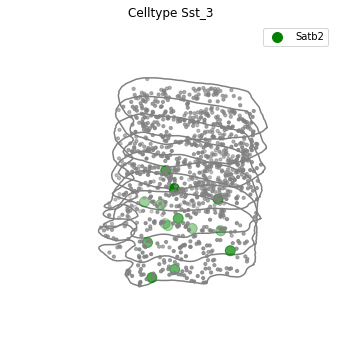

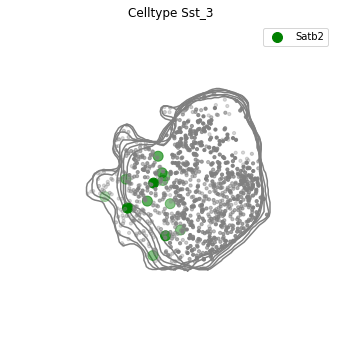

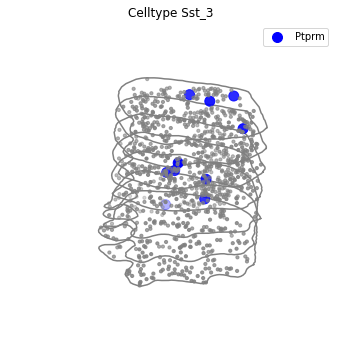

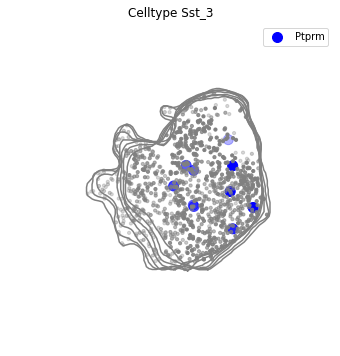

In [47]:
import importlib
importlib.reload(plotting)

gcs = [
    {'Cbln2':'red'},
    {'Satb2':'green'},
    {'Ptprm':'blue'},    
]

for gc in gcs:
    gene = list(gc.keys())[0]
    
    fig,ax = plotting.plot_cell_3D(cell, gene_colors=gc)
    plt.savefig('figure1_plots/{}_side_view.svg'.format(gene))
    plt.show(fig)
    plt.close()
    
    fig,ax = plotting.plot_cell_3D(cell, gene_colors=gc)
    ax.view_init(elev=90, azim=0)
    plt.savefig('figure1_plots/{}_top_view.svg'.format(gene))
    plt.show(fig)
    plt.close()
    

'Cbln2'

In [13]:
np.unique([1,1,2])

array([1, 2])

In [11]:
plotting.plot_cell_3D?

In [12]:
plotting.plot_cell_3D(cell, gene_colors='rainbow')
plt.show()
plt.close()

AttributeError: 'str' object has no attribute 'items'

# Comparing shrunk and un-shrunk gene/ontologies for BICCN

In [69]:
def jp(plot_df, title):
    """
    Plotting helper function
    """
    f = sns.jointplot(
        x = 'Full',
        y = 'Shrunk',
        kind = 'scatter',
        hue = 'sample_id',
        data = plot_df,
    )

    ax = f.ax_joint
    lims = [
        np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
        np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
    ]

    # now plot both limits against eachother
    ax.plot(lims, lims, 'k--', alpha=0.75, zorder=3)
    ax.set_aspect('equal')
    
    f.fig.suptitle(title)
    f.fig.tight_layout()
    f.fig.subplots_adjust(top=0.9)

    return f,ax

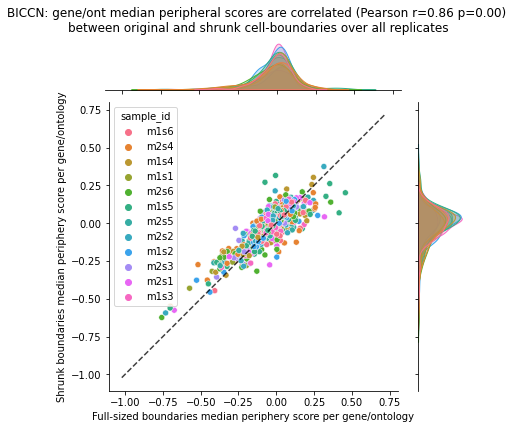

In [98]:
full_mop = pd.read_csv('../outputs/gene_ontology/MOp_peripheral_ReadZs_gene_ontology.csv')
full_mop['Cell size'] = 'Full'

shrunk_mop = pd.read_csv('../outputs/gene_ontology/MOp_shrunk_peripheral_ReadZs_gene_ontology.csv')
shrunk_mop['Cell size'] = 'Shrunk'

df = pd.concat((full_mop,shrunk_mop))

#Remove sample/gene/ontologies that aren't present in both shrunk and full sized
df = df.groupby(['sample_id','gene','ontology']).filter(lambda g: g['Cell size'].nunique() == 2)

piv_df = df.pivot(
    index=['sample_id','gene','ontology'],
    columns='Cell size',
    values='med_score',
).reset_index()

piv_df = piv_df.sample(1000) #note downsampling to reduce plot size

#plot
r,p = stats.pearsonr(piv_df['Full'], piv_df['Shrunk'])
title = (
"""BICCN: gene/ont median peripheral scores are correlated (Pearson r={:.2f} p={:.2f}) 
between original and shrunk cell-boundaries over all replicates""".format(r,p)
)
f,ax = jp(piv_df, title)
ax.set_xlabel('Full-sized boundaries median periphery score per gene/ontology')
ax.set_ylabel('Shrunk boundaries median periphery score per gene/ontology')
f.savefig('shrunk_boundaries/BICCN_periph_corr_between_orig_shrunk.svg')
plt.show(f)
plt.close()

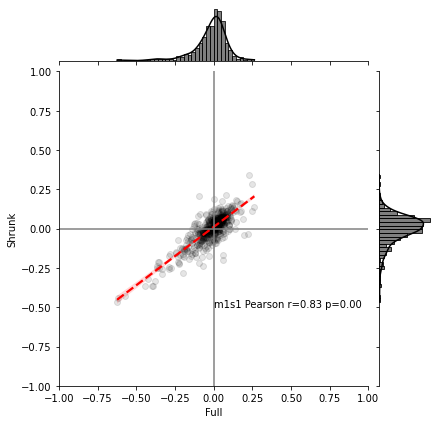

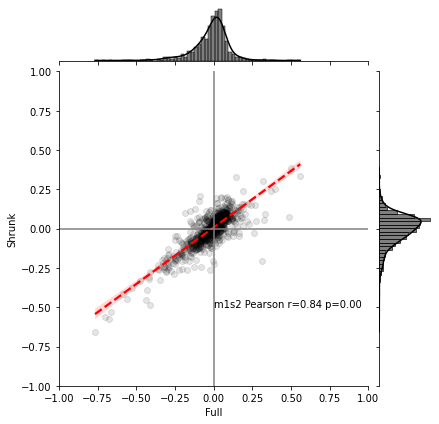

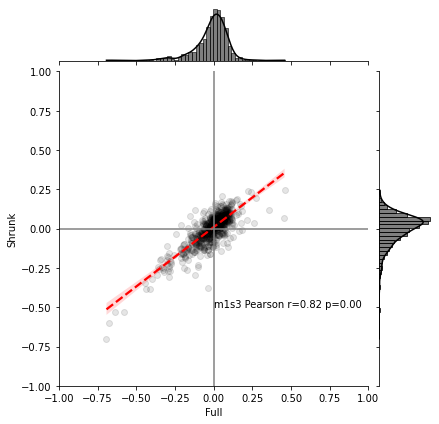

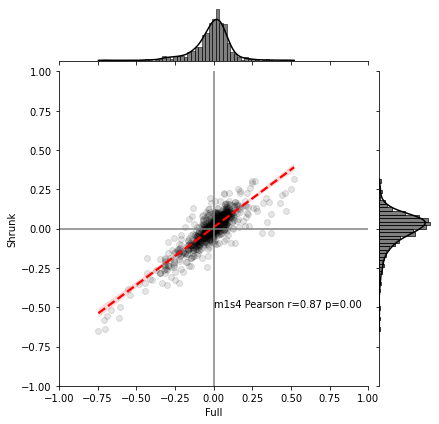

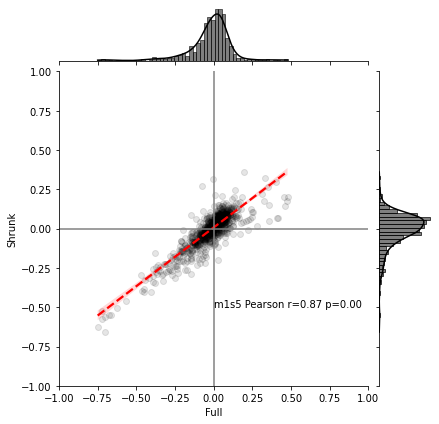

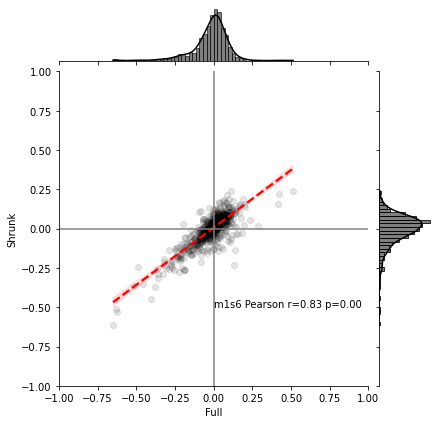

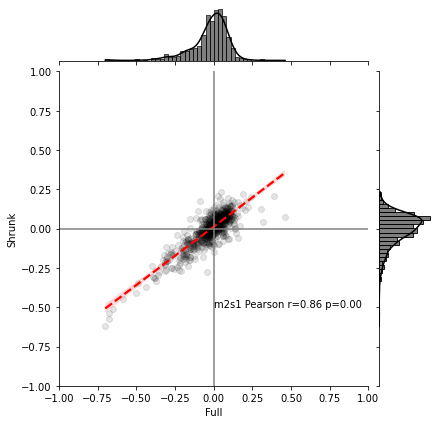

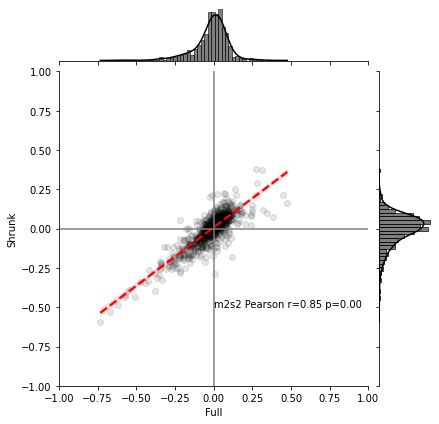

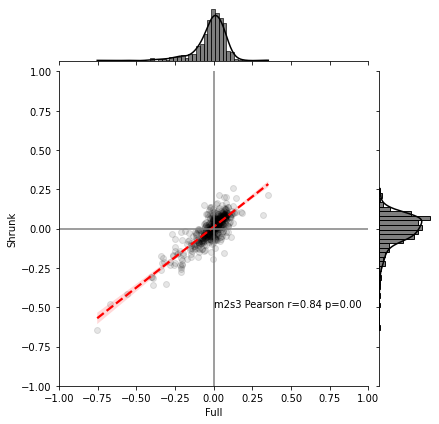

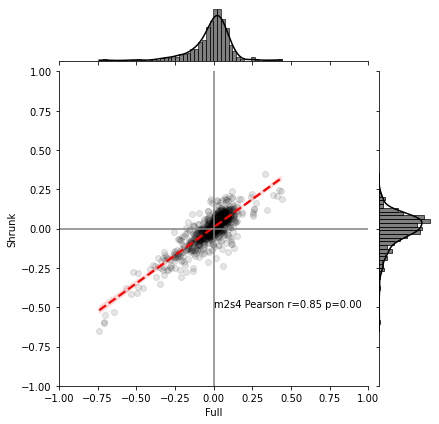

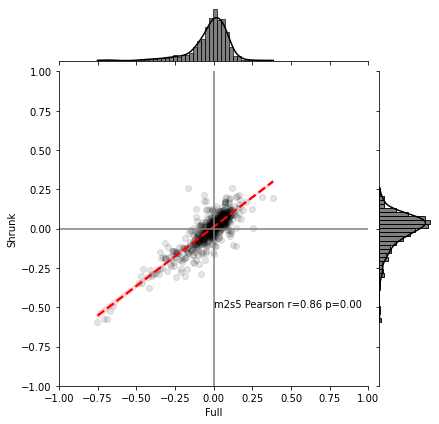

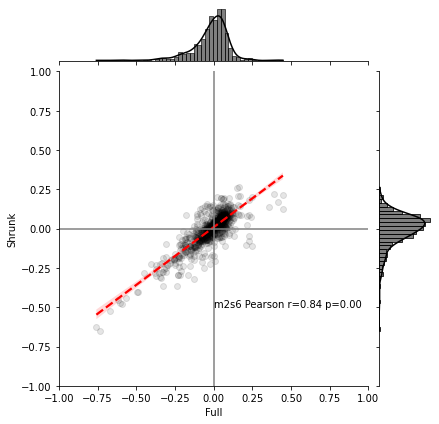

In [3]:
for i,(sample,g) in enumerate(piv_df.groupby('sample_id')):
    g = g.dropna()

    fig = sns.jointplot(
        x = 'Full',
        y = 'Shrunk',
        kind = 'reg',
        color = 'black',
        scatter_kws = {'alpha':0.1},
        line_kws = {'linestyle':'dashed','color':'red'},
        data = g,
    )
    r,p = stats.pearsonr(g['Full'], g['Shrunk'])
    
    fig.ax_joint.set_xlim(-1,1)
    fig.ax_joint.set_ylim(-1,1)
    fig.ax_joint.axhline(0,color='grey')
    fig.ax_joint.axvline(0,color='grey')
    fig.ax_joint.text(0,-0.5,'{} Pearson r={:.2f} p={:.2f}'.format(sample,r,p))
    plt.show()
    plt.close()



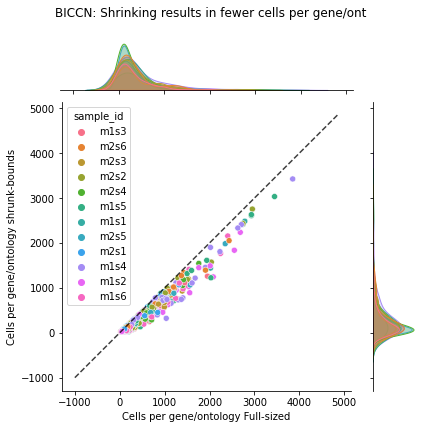

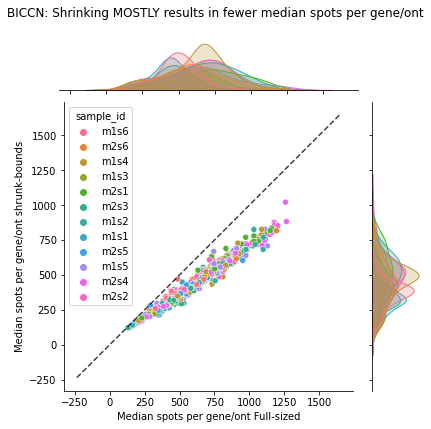

Reason why some gene/onts can have higher median spots is because low-count cells are filtered out


In [99]:
#plot cell counts per gene/ont
cell_count_piv_df = df.pivot(
    index=['sample_id','gene','ontology'],
    columns='Cell size',
    values='num_cells',
).reset_index()

cell_count_piv_df = cell_count_piv_df.sample(1000)

title = 'BICCN: Shrinking results in fewer cells per gene/ont'
f,ax = jp(cell_count_piv_df, title)
ax.set_xlabel('Cells per gene/ontology Full-sized')
ax.set_ylabel('Cells per gene/ontology shrunk-bounds')
f.savefig('shrunk_boundaries/BICCN_shrunk_gene_onts_fewer_cells.svg')
plt.show(f)
plt.close()

#plot median spot counts per gene/ont
spot_count_piv_df = df.pivot(
    index=['sample_id','gene','ontology'],
    columns='Cell size',
    values='med_spots',
).reset_index()

spot_count_piv_df = spot_count_piv_df.sample(1000)

title = 'BICCN: Shrinking MOSTLY results in fewer median spots per gene/ont'
f,ax = jp(spot_count_piv_df, title)
ax.set_xlabel('Median spots per gene/ont Full-sized')
ax.set_ylabel('Median spots per gene/ont shrunk-bounds')
f.savefig('shrunk_boundaries/BICCN_shrunk_gene_onts_fewer_med_spots.svg')
plt.show(f)
plt.close()


print('Reason why some gene/onts can have higher median spots is because low-count cells are filtered out')

# Comparing shrunk and un-shrunk gene/ontologies for Viz Brainmap

In [90]:
piv_df

Cell size,sample_id,gene,ontology,Full,Shrunk
0,s1r1,Ackr1,0,0.009465,NaN
1,s1r1,Ackr1,1,-0.019802,NaN
2,s1r1,Ackr1,5,-0.017282,NaN
3,s1r1,Ackr1,7,-0.029520,NaN
4,s1r1,Ackr1,11,-0.047297,NaN
...,...,...,...,...,...
4736,s3r3,Tyro3,21,NaN,-0.005300
4737,s3r3,Tyro3,23,-0.039913,NaN
4738,s3r3,Tyro3,26,-0.027192,NaN
4739,s3r3,Tyro3,31,NaN,-0.043478


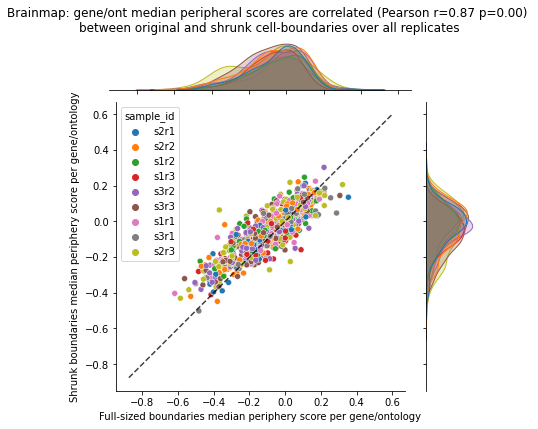

In [97]:
full_viz = pd.read_csv('../outputs/gene_ontology/Vizgen_Brainmap_peripheral.csv')
full_viz['Cell size'] = 'Full'
full_viz['ontology'] = full_viz['annotation']

shrunk_viz = pd.read_csv('../outputs/gene_ontology/Viz_shrunk_periph.csv')
shrunk_viz['Cell size'] = 'Shrunk'
shrunk_viz['sample_id'] = shrunk_viz['sample_id'].str.lower()

df = pd.concat((full_viz,shrunk_viz))

#Remove sample/gene/ontologies that aren't present in both shrunk and full sized
df = df.groupby(['sample_id','gene','ontology']).filter(lambda g: g['Cell size'].nunique() == 2)

piv_df = df.pivot( 
    index=['sample_id','gene','ontology'],
    columns='Cell size',
    values='med_score',
).reset_index()

piv_df = piv_df.sample(1000) #note downsampling to reduce plot size
#plot
r,p = stats.pearsonr(piv_df['Full'], piv_df['Shrunk'])
title = (
"""Brainmap: gene/ont median peripheral scores are correlated (Pearson r={:.2f} p={:.2f}) 
between original and shrunk cell-boundaries over all replicates""".format(r,p)
)
f,ax = jp(piv_df, title)
ax.set_xlabel('Full-sized boundaries median periphery score per gene/ontology')
ax.set_ylabel('Shrunk boundaries median periphery score per gene/ontology')
f.savefig('shrunk_boundaries/Brainmap_periph_corr_between_orig_shrunk.svg')
plt.show(f)
plt.close()

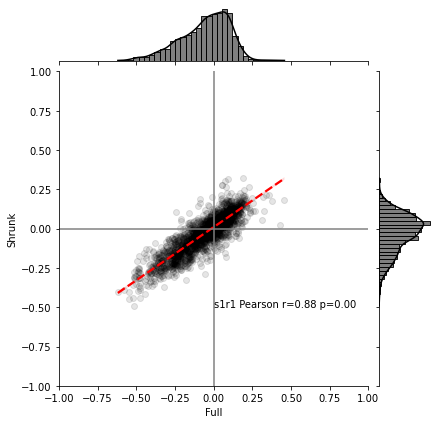

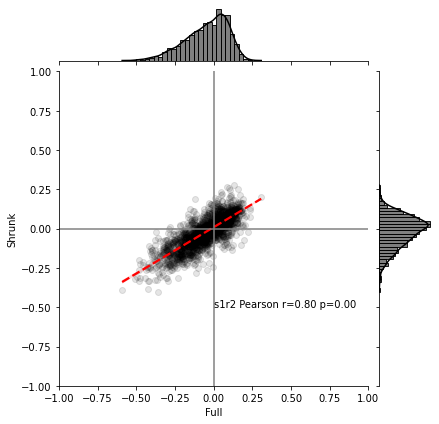

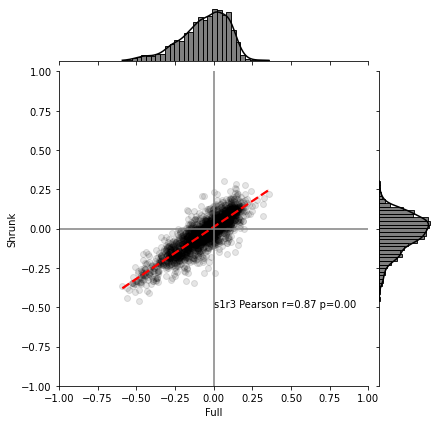

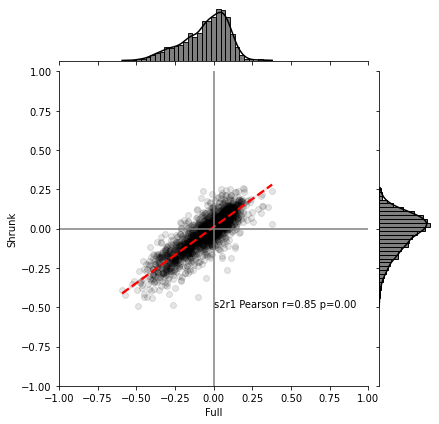

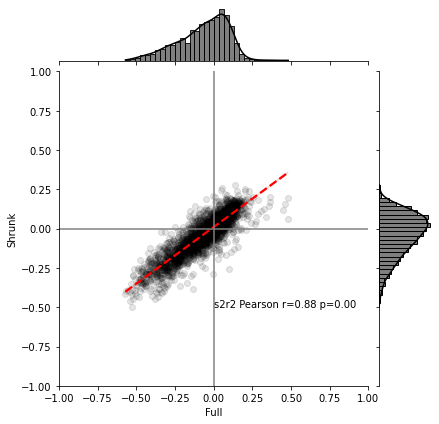

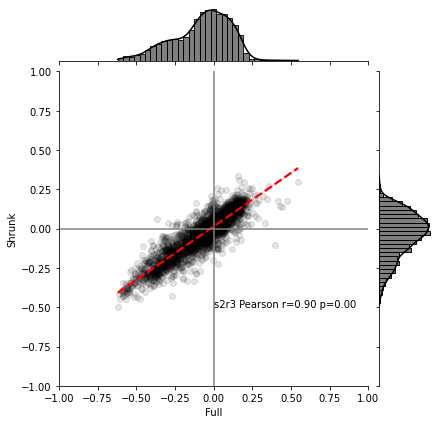

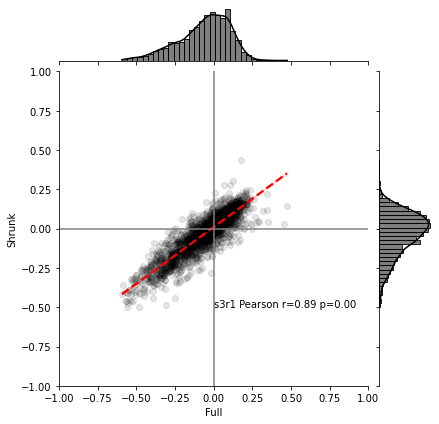

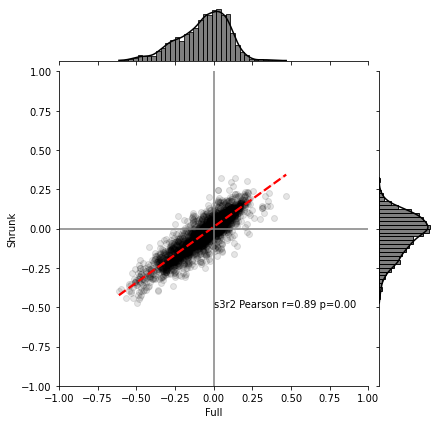

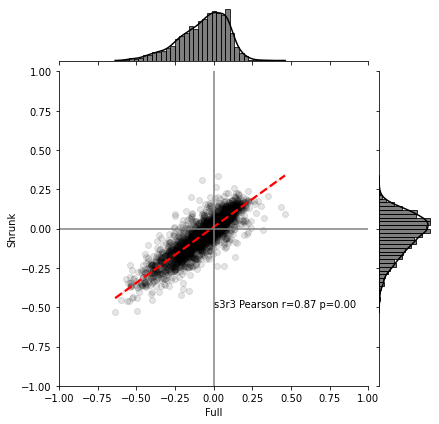

In [40]:
#breaking each sample into a separate plot
for i,(sample,g) in enumerate(piv_df.groupby('sample_id')):
    g = g.dropna()

    fig = sns.jointplot(
        x = 'Full',
        y = 'Shrunk',
        kind = 'reg',
        color = 'black',
        scatter_kws = {'alpha':0.1},
        line_kws = {'linestyle':'dashed','color':'red'},
        data = g,
    )
    r,p = stats.pearsonr(g['Full'], g['Shrunk'])
    
    fig.ax_joint.set_xlim(-1,1)
    fig.ax_joint.set_ylim(-1,1)
    fig.ax_joint.axhline(0,color='grey')
    fig.ax_joint.axvline(0,color='grey')
    fig.ax_joint.text(0,-0.5,'{} Pearson r={:.2f} p={:.2f}'.format(sample,r,p))
    plt.show()
    plt.close()

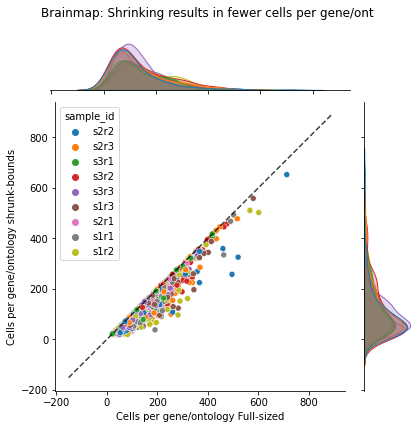

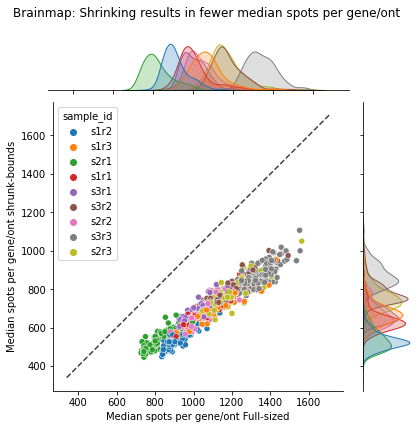

In [96]:
# Cells per gene/ontology plot
cell_count_piv_df = df.pivot(
    index=['sample_id','gene','ontology'],
    columns='Cell size',
    values='num_cells',
).reset_index()

cell_count_piv_df = cell_count_piv_df.sample(1000)

title = 'Brainmap: Shrinking results in fewer cells per gene/ont'
f,ax = jp(cell_count_piv_df,title)
ax.set_xlabel('Cells per gene/ontology Full-sized')
ax.set_ylabel('Cells per gene/ontology shrunk-bounds')
f.savefig('shrunk_boundaries/Brainmap_shrunk_gene_onts_fewer_cells.svg')
plt.show(f)
plt.close()

# Median spots per gene/ontology plot
spot_count_piv_df = df.pivot(
    index=['sample_id','gene','ontology'],
    columns='Cell size',
    values='med_spots',
).reset_index()

spot_count_piv_df = spot_count_piv_df.sample(1000)

title = 'Brainmap: Shrinking results in fewer median spots per gene/ont'
f,ax = jp(spot_count_piv_df, title)
ax.set_xlabel('Median spots per gene/ont Full-sized')
ax.set_ylabel('Median spots per gene/ont shrunk-bounds')
f.savefig('shrunk_boundaries/Brainmap_shrunk_gene_onts_fewer_med_spots.svg')
plt.show(f)
plt.close()

# Combining the shrunk per-sample files for Brainmap and BICCN

Creating a single file for the gene/cell data which I'll then aggregate to gene/ontology

In [10]:
vz_brainmap_paths = sorted(glob.glob('/oak/stanford/groups/horence/rob/isoform_localizations/SRRS/inputs/shrunk_cells/Slice*_periph.csv'))

#Vizgen Brainmap data
out_path = '../outputs/gene_cell/Viz_shrunk_periph.csv'

for i,p in enumerate(vz_brainmap_paths):
    s,r = os.path.basename(p).split('_')[:2]
    s,r = s[-1],r[-1]
    print(s,r)
    
    df = pd.read_csv(p)
    df['mouse'] = 1
    df['sample'] = s
    df['replicate'] = r
    df['sample_id'] = 'S{}R{}'.format(s,r)
    
    df.to_csv(out_path, mode=('w' if i==0 else 'a'), header=i==0, index=False)
    

1 1
1 2
1 3
2 1
2 2
2 3
3 1
3 2
3 3


In [ ]:
biccn_paths = sorted(glob.glob('/oak/stanford/groups/horence/rob/isoform_localizations/SRRS/inputs/shrunk_cells/mouse*_periph.csv'))

#BICCN MOp data
out_path = '../outputs/gene_cell/MOp_shrunk_periph.csv'

for i,p in enumerate(biccn_paths):
    m,s = os.path.basename(p).split('_periph')[0].replace('mouse','').split('sample')
    print(m,s)
    
    df = pd.read_csv(p)
    df['mouse'] = int(m)
    df['sample'] = int(s)
    df['replicate'] = 1
    df['sample_id'] = 'm{}s{}'.format(m,s)
    
    df.to_csv(out_path, mode=('w' if i==0 else 'a'), header=i==0, index=False)
    

1 1
1 2
1 3
1 4
1 5


# Sandbox of how to do the shrinking

In [2]:
sample = SRRS.HDF5('../inputs/m1s1_subset.hdf5')
sample.num_cells

152

In [3]:
sample.cell_ids[:10]

['100090299132393774825374529480599642352',
 '102762322167228082486052775619884277102',
 '103963394979214788325793179983943807873',
 '104773525917171323315032845506736864421',
 '104887114217211410540888577620028568901',
 '106736575396305345683133461207739252997',
 '106771113274834466403933341586053551462',
 '111300904473796808480218743996654298162',
 '114601597319929030309061287706907914361',
 '114794480420405132420944298037591232478']

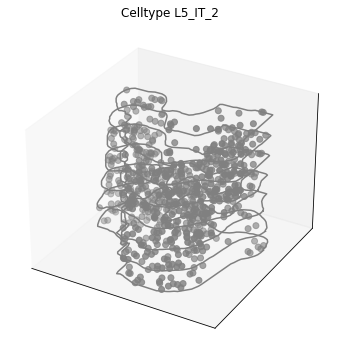

In [10]:
cell = sample.get_cells_by_id(['103963394979214788325793179983943807873'])[0]
plotting.plot_cell_3D(cell)
plt.show()
plt.close()

In [12]:
new_cell = cell.shrink_boundaries(scale_factor=0.8)
new_cell

Cell-103963394979214788325793179983943807873-L5_IT_2

In [13]:
cell.n

700

In [14]:
new_cell.n

448

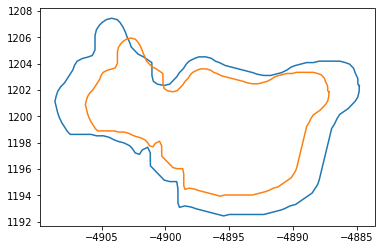

In [15]:
s = shapely.geometry.Polygon(cell.boundaries['0'])
small_s = shapely.geometry.Polygon(new_cell.boundaries['0'])

plt.plot(*s.exterior.xy)
plt.plot(*small_s.exterior.xy)
plt.show()
plt.close()

In [35]:
shrunk_cells = (c.shrink_boundaries(scale_factor=0.8) for c in sample.iter_cells())
shrunk_cells = list(SRRS.scoring._iter_vars(shrunk_cells))
shrunk_cells[0]

Cell-100090299132393774825374529480599642352-Astro_1

In [36]:
shrunk_cells[0].gene_vars

{'Cdh20': 0.1836734693877551,
 'Col25a1': 0.42857142857142855,
 'Ctss': 0.42857142857142855,
 'Cxcl14': 0.42857142857142855,
 'Frem2': 0.42857142857142855,
 'Rgs6': 0.1836734693877551}

In [38]:
s.area

199.56458129500757